
# Transfer Learning con ResNet18, DenseNet121 y VGG16

In [3]:
%pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.9 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256

In [8]:

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.models import ResNet18_Weights, DenseNet121_Weights, VGG16_Weights
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cargar dataset
data_flag = 'breastmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

train_dataset = DataClass(split='train', transform=transform, download=True)
test_dataset = DataClass(split='test', transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [10]:
def get_model(name, num_classes=1):
    if name == 'resnet':
        from torchvision.models import resnet18, ResNet18_Weights
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
        in_features = model.fc.in_features
        model.fc = nn.Sequential(nn.Linear(in_features, num_classes), nn.Sigmoid())

    elif name == 'densenet':
        from torchvision.models import densenet121, DenseNet121_Weights
        model = densenet121(weights=DenseNet121_Weights.DEFAULT)
        in_features = model.classifier.in_features
        model.classifier = nn.Sequential(nn.Linear(in_features, num_classes), nn.Sigmoid())

    elif name == 'vgg':
        from torchvision.models import vgg16, VGG16_Weights
        model = vgg16(weights=VGG16_Weights.DEFAULT)
        in_features = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(nn.Linear(in_features, num_classes), nn.Sigmoid())

    # Congelar todas las capas excepto la cabeza (fc)
    for param in model.parameters():
        param.requires_grad = False

    # Solo entrenar la cabeza
    if name == 'resnet':
        for param in model.fc.parameters():
            param.requires_grad = True
    elif name == 'densenet':
        for param in model.classifier.parameters():
            param.requires_grad = True
    elif name == 'vgg':
        for param in model.classifier[6].parameters():
            param.requires_grad = True

    return model

In [11]:

def train_and_evaluate(model, name):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    # Entrenamiento
    for epoch in range(5):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for imgs, labels in train_loader:
            labels = labels.float().reshape(-1, 1)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        acc = correct / total
        print(f"[{name}] Epoch {epoch+1}: Loss={total_loss:.4f}, Train Acc={acc:.4f}")

    # Evaluación
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            labels = labels.float().reshape(-1, 1)
            outputs = model(imgs)
            y_true.extend(labels.numpy())
            y_pred.extend(outputs.numpy())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_class = (y_pred > 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred_class)
    f1 = f1_score(y_true, y_pred_class)
    prec = precision_score(y_true, y_pred_class)
    rec = recall_score(y_true, y_pred_class)
    roc_auc = roc_auc_score(y_true, y_pred)

    print(f"\n{name.upper()} Results:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"AUC-ROC:   {roc_auc:.4f}")

    # Curvas y matriz de confusión
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred_class)

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
    plt.title(f"{name.upper()} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    plt.subplot(1, 3, 2)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(recall_curve, precision_curve)
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.tight_layout()
    plt.show()



Entrenando modelo: RESNET
[resnet] Epoch 1: Loss=10.8817, Train Acc=0.7326
[resnet] Epoch 2: Loss=9.6152, Train Acc=0.7381
[resnet] Epoch 3: Loss=8.9780, Train Acc=0.7601
[resnet] Epoch 4: Loss=8.6594, Train Acc=0.7601
[resnet] Epoch 5: Loss=8.5238, Train Acc=0.7747

RESNET Results:
Accuracy:  0.7756
F1 Score:  0.8659
Precision: 0.7687
Recall:    0.9912
AUC-ROC:   0.7757


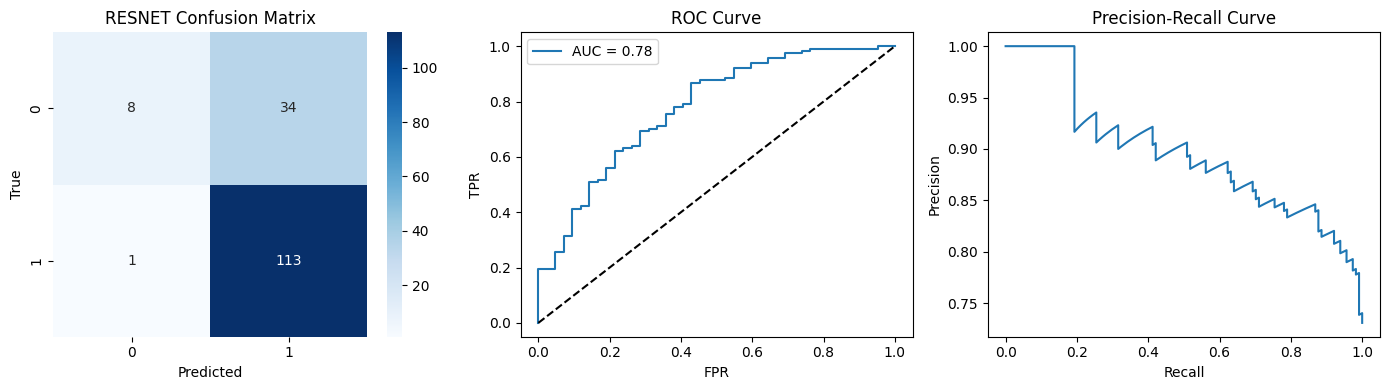


Entrenando modelo: DENSENET


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 217MB/s]


[densenet] Epoch 1: Loss=10.4311, Train Acc=0.7308
[densenet] Epoch 2: Loss=10.4611, Train Acc=0.7344
[densenet] Epoch 3: Loss=9.3589, Train Acc=0.7436
[densenet] Epoch 4: Loss=8.8670, Train Acc=0.7473
[densenet] Epoch 5: Loss=8.5263, Train Acc=0.7802

DENSENET Results:
Accuracy:  0.7564
F1 Score:  0.8571
Precision: 0.7500
Recall:    1.0000
AUC-ROC:   0.7490


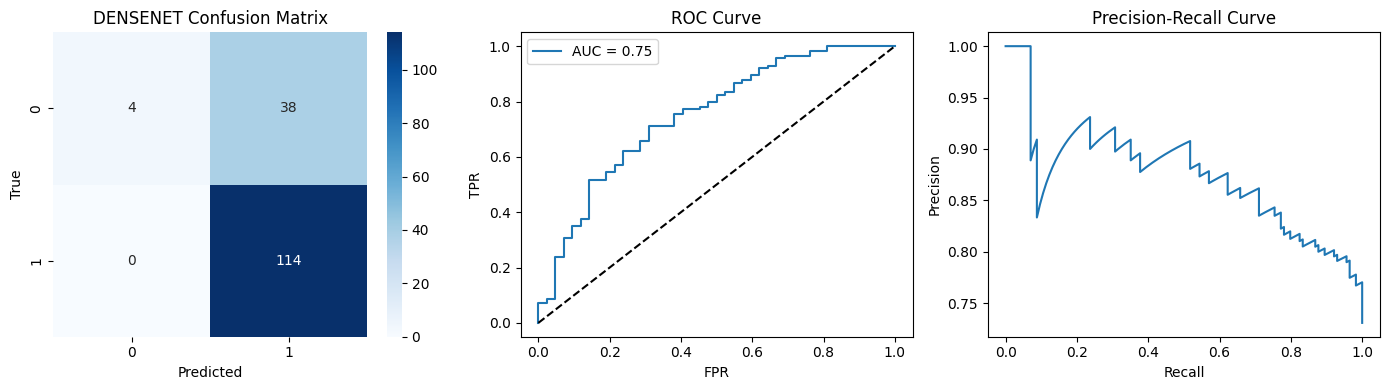


Entrenando modelo: VGG


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 78.9MB/s]


[vgg] Epoch 1: Loss=10.3049, Train Acc=0.7289
[vgg] Epoch 2: Loss=9.4872, Train Acc=0.7308
[vgg] Epoch 3: Loss=9.2679, Train Acc=0.7509
[vgg] Epoch 4: Loss=9.1418, Train Acc=0.7564
[vgg] Epoch 5: Loss=8.7353, Train Acc=0.7711

VGG Results:
Accuracy:  0.7756
F1 Score:  0.8627
Precision: 0.7801
Recall:    0.9649
AUC-ROC:   0.7749


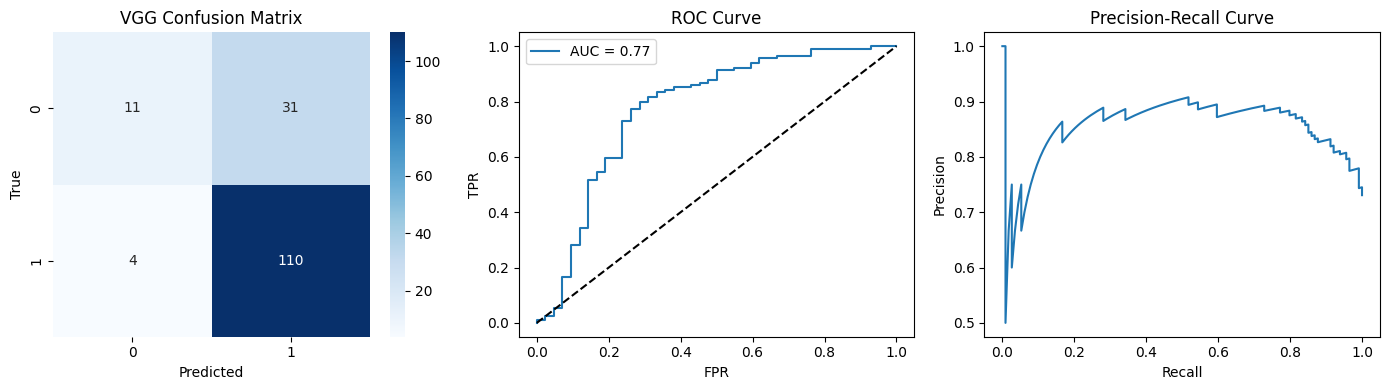

In [12]:

for name in ['resnet', 'densenet', 'vgg']:
    print(f"\nEntrenando modelo: {name.upper()}")
    model = get_model(name)
    train_and_evaluate(model, name)
